In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, UpSampling2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, accuracy_score, zero_one_loss, balanced_accuracy_score, average_precision_score
from inspect import signature
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
import os
import pickle
import sys
import logging
from tensorflow.keras import layers
from tensorflow.keras import Input
import seaborn as sns
from tensorflow.keras import backend
from sklearn.metrics import classification_report

In [ ]:
#backend.set_image_data_format('channels_last')

In [2]:
def get_vgg16():
    model = Sequential()

    # Encoder
    # Block 1
    model.add(BatchNormalization(axis=3, input_shape=(80, 120, 3)))
    #model.add(Dropout(.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block1_conv1', input_shape=(80,120,3)))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block1_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

    # Block 2
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block2_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block2_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

    # Block 3
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block3_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block3_conv2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

    # Block 4
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block4_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block4_conv2'))
    model.add(MaxPooling2D((2, 3), strides=(2, 3), name='block4_pool'))


    # Block 5
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block5_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block5_conv2'))

    # Decoder
    # Block 6
    model.add(UpSampling2D((2, 3), name='block6_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block6_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block6_conv2'))

    # Block 7
    model.add(UpSampling2D((2, 2), name='block7_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block7_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block7_conv2'))

    # Block 8
    model.add(UpSampling2D((2, 2), name='block8_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block8_conv1'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block8_conv2'))

    # Block 9
    model.add(UpSampling2D((2, 2), name='block9_upsampl'))
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block9_conv1'))
    model.add(BatchNormalization(axis=3))
    #model.add(Dropout(.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block9_conv2'))

    # Output
    model.add(BatchNormalization(axis=3))
    model.add(Conv2D(1, (1, 1), padding='same', activation='relu', bias_regularizer=regularizers.l1(0.01), name='block10_conv1'))

    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mae', optimizer=sgd, metrics=['mse', 'acc'])
    #model.compile(loss='mae', optimizer=Adam(lr=0.001), metrics=['mse'])
    print(model.summary())

    return model

model = get_vgg16()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 80, 120, 3)        12        
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 120, 64)       1792      
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 120, 64)       256       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 120, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 60, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 40, 60, 64)        256       
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 60, 128)       7

In [3]:
x_train = np.load("/opt/datos/dataset/x_train-0_3_5_levels.npy")
x_test = np.load("/opt/datos/dataset/x_test-0_3_5_levels.npy")
y_train = np.load("/opt/datos/dataset/y_train-0_3_5_levels.npy")
y_test = np.load("/opt/datos/dataset/y_test-0_3_5_levels.npy")

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

i = 0
j = 3
k = 5

(40000, 80, 120, 3)
(14023, 80, 120, 3)
(40000, 80, 120, 1)
(14023, 80, 120, 1)


In [4]:
history = model.fit(x_train, y_train, epochs=50, verbose=1, validation_data=(x_test, y_test))

Epoch 1/50
1250/1250 [==============================] - 594s 458ms/step - loss: 0.4244 - mse: 1.5409 - acc: 0.3983 - val_loss: 0.3700 - val_mse: 1.2096 - val_acc: 0.4026
Epoch 2/50
1250/1250 [==============================] - 561s 449ms/step - loss: 0.3574 - mse: 1.1127 - acc: 0.4046 - val_loss: 0.3466 - val_mse: 0.9849 - val_acc: 0.4010
Epoch 3/50
1250/1250 [==============================] - 560s 448ms/step - loss: 0.3344 - mse: 0.9570 - acc: 0.4044 - val_loss: 0.3290 - val_mse: 0.9219 - val_acc: 0.4033
Epoch 4/50
1250/1250 [==============================] - 560s 448ms/step - loss: 0.3203 - mse: 0.8710 - acc: 0.4054 - val_loss: 0.3208 - val_mse: 0.8765 - val_acc: 0.4033
Epoch 5/50
1250/1250 [==============================] - 560s 448ms/step - loss: 0.3095 - mse: 0.8042 - acc: 0.4038 - val_loss: 0.3129 - val_mse: 0.8389 - val_acc: 0.4042
Epoch 6/50
1250/1250 [==============================] - 560s 448ms/step - loss: 0.3005 - mse: 0.7544 - acc: 0.4042 - val_loss: 0.3082 - val_mse: 0.781

Epoch 49/50
1250/1250 [==============================] - 560s 448ms/step - loss: 0.1911 - mse: 0.2577 - acc: 0.4078 - val_loss: 0.2671 - val_mse: 0.5688 - val_acc: 0.4045
Epoch 50/50
1250/1250 [==============================] - 560s 448ms/step - loss: 0.1903 - mse: 0.2548 - acc: 0.4069 - val_loss: 0.2676 - val_mse: 0.5685 - val_acc: 0.4045


In [5]:
with open('/opt/datos/entrenamientos/larraondo/trainHistoryDict_vgg16_{}-{}-{}'.format(i, j, k), 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [6]:
history = pickle.load( open( "/opt/datos/entrenamientos/larraondo/trainHistoryDict_vgg16_0-3-5", "rb" ) )

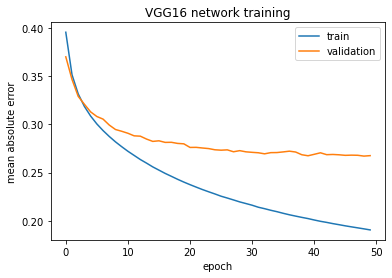

In [7]:
#print(history)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('VGG16 network training')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [8]:
model.save('/opt/datos/entrenamientos/larraondo/vgg16_0_3_5.h5')

In [31]:
y_pred = model.predict(X_test)
print(y_pred.shape)

(7000, 80, 120, 1)


In [26]:
# Para ver que valores hay y cuantas veces aparece c/u
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
# Cuento la cantidad de unos y ceros en las matrices de tags
lluvias = np.where(Y_test==1)[0].size
nolluvias = np.where(Y_test==0)[0].size

print("Cantidad de unos que hay realmente: " + str(lluvias))
print("Cantidad de ceros que hay realmente: " + str(nolluvias))
total_real = lluvias+nolluvias
print("Total: " + str(total_real))

Cantidad de unos que hay realmente: 8036754
Cantidad de ceros que hay realmente: 59163246
Total: 67200000


In [33]:
# Cuento la cantidad de unos y ceros en las matrices de prediccion
unos = np.where(y_pred == 1)[0].size
ceros = np.where(y_pred == 0)[0].size
otro_valor = np.where(y_pred != 0)[0].size

print("Cantidad de unos predichos: " + str(unos))
print("Cantidad de ceros predichos: " + str(ceros))
print("Cantidad de valores distintos de cero: " + str(otro_valor))
total_real = unos+ceros
print("Total: " + str(total_real))

Cantidad de unos predichos: 2
Cantidad de ceros predichos: 61200618
Cantidad de valores distintos de cero: 5999382
Total: 61200620


In [34]:
y_pred[y_pred >= 0.5] = 1
y_pred[y_pred < 0.5] = 0

Y_test: (67200000,)
y_pred: (67200000,)


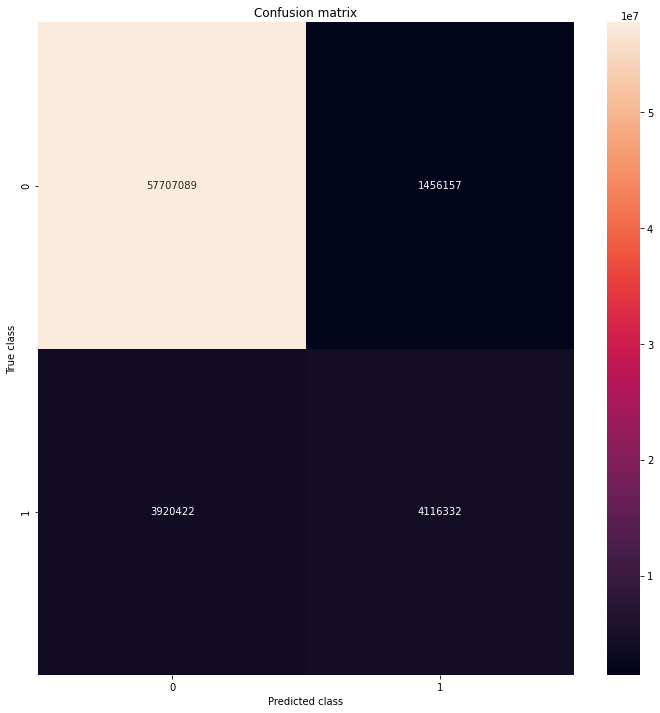

              precision    recall  f1-score   support

         0.0       0.94      0.98      0.96  59163246
         1.0       0.74      0.51      0.60   8036754

    accuracy                           0.92  67200000
   macro avg       0.84      0.74      0.78  67200000
weighted avg       0.91      0.92      0.91  67200000



In [35]:
Y_test = Y_test.reshape(7000*80*120)
y_pred = y_pred.reshape(7000*80*120)
print("Y_test: %s" %str(Y_test.shape))
print("y_pred: %s" %str(y_pred.shape))

predije = ["0", "1"]
def mostrar_resultados(Y_test, y_pred):
    conf_matrix = confusion_matrix(Y_test, y_pred)
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=predije, yticklabels=predije, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()
    print (classification_report(Y_test, y_pred))


mostrar_resultados(Y_test, y_pred)